# SISTEMA DE VIDEO ANOTACION


## Integrantes

- Darwin Lenis
- Juan Felipe Madrid
- Jacobo Ossa
- Luis Pinillos

## 1. Introduccion:

Este proyecto tiene como objetivo desarrollar una herramienta de software que analice actividades humanas específicas de movimiento (como caminar, girar, sentarse y ponerse de pie) utilizando un sistema de video en tiempo real. La solución se centra en el seguimiento de movimientos articulares y posturales, y proporciona clasificaciones y análisis en tiempo real a traves del entrenamiento de varios modelos de inteligencia artificial que permitan la clasificacion de estos movimientos.

## 2. Proceso de Recolección y Análisis de Datos



### 2.1 Grabación de Videos:



  Para emperzar con el desarrollo del proyecto es necesario tener un dataset que nos permita hacer el entrenamiento y prueba de los modelos a entrenar, para esto y teniendo en cuenta que lo que buscamos es clasificar movimientos en tiempo real, se grabaron distintas personas realizando movimientos como sentarse, caminar, girar, inclinarse, alejarse y acercarse desde un punto fijo. De estos videos se espera sacar los datos necesarios para crear el dataset base.

  

### 2.2 Análisis con MediaPipe:


De la grabacion del video no se pueden sacar datos por si solo, por lo cual es necesario hacer uso de una herramientas que nos permita hacerlo. Por lo anterior, se utilizó MediaPipe que es una plataforma de Google desarrollada para crear soluciones de procesamiento de visión por computadora y aprendizaje automático. Ofrece una serie de herramientas y modelos listos para usar que pueden ser integrados en aplicaciones para tareas como la detección de rostros, el seguimiento de manos, la estimación de poses corporales, la segmentación de objetos, y más. Especificamente se uso la seccion de "detección de puntos de referencia de posiciones", ya que esto nos permite hacer un seguimiento de cuerpo completo de los videos grabados.

https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419

MediaPipe procesa los videos para identificar 33 articulaciones del cuerpo humano en cada frame, cada articulacion que su respectivo identificador, incluyendo:
* Cabeza (nariz, ojos, orejas)
* Hombros, codos, muñecas, manos
* Caderas, rodillas, tobillos, pies




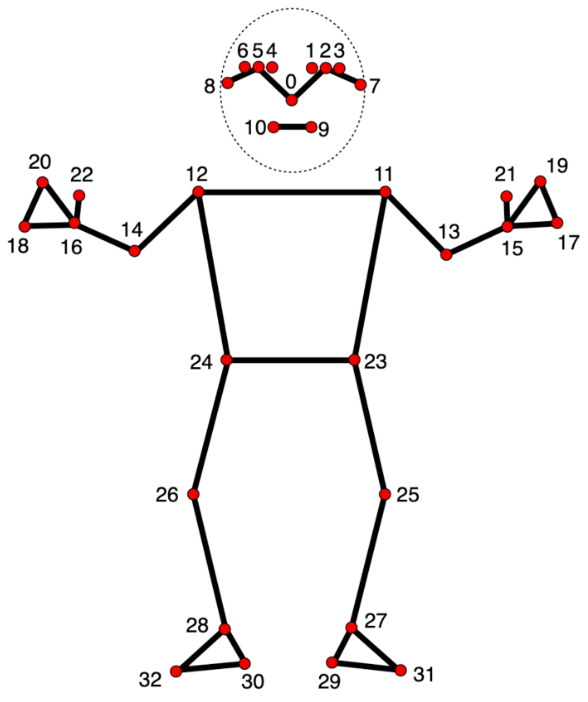

- 0 - nose
- 1 - left eye (inner)
- 2 - left eye
- 3 - left eye (outer)
- 4 - right eye (inner)
- 5 - right eye
- 6 - right eye (outer)
- 7 - left ear
- 8 - right ear
- 9 - mouth (left)
- 10 - mouth (right)
- 11 - left shoulder
- 12 - right shoulder
- 13 - left elbow
- 14 - right elbow
- 15 - left wrist
- 16 - right wrist
- 17 - left pinky
- 18 - right pinky
- 19 - left index
- 20 - right index
- 21 - left thumb
- 22 - right thumb
- 23 - left hip
- 24 - right hip
- 25 - left knee
- 26 - right knee
- 27 - left ankle
- 28 - right ankle
- 29 - left heel
- 30 - right heel
- 31 - left foot index
- 32 - right foot index

### 2.3 Generación de Datos:







Con la ayuda MediaPipe se generaron coordenadas tridimensionales (x, y, z) para cada articulación. Estos datos son los que haran parte del dataset base.

Lo primero que se hizo fue establecer la etiqueta que actuara como clase, esto permitira diferencia que se esta haciendo en cada frame del dataset y a medida que se analiza el video, extrae las coordenadas tridimensionales

Un aspecto muy importante es que se decidio agrupar cada 5 frames, esto con el proposito de que el entrenamiento del modelo fuera correcto, ya que si se dejan los datos frame por frame el modelo no va a detectar un cambio significativo en las coordenadas. Asi que al juntar por grupos a los frames, se va a poder diferenciar el cambio de coordenadas en los diferentes movimientos, lo que le da contexto al modelo sobre cómo se mueve el cuerpo a través del tiempo. El hecho de que el cuerpo cambie de posición en varias articulaciones a lo largo de varios frames es clave para que el modelo aprenda patrones temporales y entienda el contexto de lo que está viendo, si solo les das información de un frame, no pueden ver ese cambio.

Adicionalmente, estos datos se guardan de forma vectorial, lo que es importante para que el modelo de IA pueda procesar estos datos eficientemente. Los modelos de IA están optimizados para trabajar con vectores de características, donde cada característica (en este caso, cada coordenada X, Y, Z a lo largo de varios frames) ayuda a definir el patrón de movimiento en la actividad humana.

Ventajas de agrupar en vectores:

* **Mejor representación del movimiento:** Al agrupar varios frames en un vector, el modelo puede ver cómo cambian las articulaciones a lo largo de varios momentos, lo que es crucial para detectar patrones de movimiento.
* **Menos datos, más información:** En lugar de procesar cada frame individualmente (lo que haría que el modelo trate de entender el movimiento solo a partir de un frame), el modelo puede ver una secuencia de frames y entender el movimiento en conjunto, lo cual es más efectivo para entrenar.
* **Reducción de ruido:** Si el modelo viera cada frame individualmente, podría sobreajustarse a pequeños cambios aleatorios que ocurren en un solo frame. Al ver un grupo de frames, el modelo puede aprender el patrón general del movimiento y no distraerse con pequeñas variaciones.


Para cada frame:
* 495 columnas de coordenadas (33 articulaciones * 3 coordenadas)
* 1 columna de etiqueta de actividad

Estructura del Dataset:
* 495 columnas: coordenadas de articulaciones
* 1 columna: etiqueta de actividad (ej. "Sentarse", "Girando")

Ya con cada dataset extraido de cada uno de los videos, se concatenaron todos para tener un solo dataset con toda la informacion.


#### Codigo usado para el extraccion de datos de los videos grabados:

In [ ]:
import cv2
import mediapipe as mp
import csv
import numpy as np

# Inicializamos MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Etiqueta de la acción (puedes cambiarla dependiendo del video que proceses)
action_label = "Sentarse"

# Ruta del video (puedes cambiarla según el video que proceses)
video_path = './Desktop/ProyectoIA/Entrega1/Videos/Sentado_User4.mp4'
cap = cv2.VideoCapture(video_path)

# Abrimos un archivo CSV para guardar los datos del dataset
with open('./Desktop/ProyectoIA/Entrega1/Dataset_Info/dataset_sentarse_user4.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # Escribimos el encabezado del CSV
    header = ['label']
    for frame_idx in range(5):  # 5 frames agrupados
        for i in range(33):  # 33 puntos mapeados
            header += [f'x{frame_idx}_{i}', f'y{frame_idx}_{i}', f'z{frame_idx}_{i}']
    writer.writerow(header)

    # Variables para agrupar los frames
    group_of_frames = []
    frame_counter = 0

    # Procesamos cada frame del video
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Convertimos el frame de BGR a RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Procesamos el frame con MediaPipe para detectar las articulaciones
        results = pose.process(rgb_frame)

        # Si se detectan las articulaciones
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            frame_data = []

            # Extraemos las coordenadas x, y, z de cada articulación
            for landmark in landmarks:
                frame_data.append(landmark.x)
                frame_data.append(landmark.y)
                frame_data.append(landmark.z)

            # Añadimos las coordenadas del frame actual al grupo de frames
            group_of_frames.append(frame_data)
            frame_counter += 1

            # Cuando se tienen 5 frames, concatenamos las coordenadas en un solo vector
            if frame_counter == 5:
                combined_vector = [action_label]  # Añadimos la etiqueta al inicio
                for frame in group_of_frames:
                    combined_vector.extend(frame)  # Concatenamos las coordenadas de los 5 frames

                # Escribimos el vector combinado en el CSV
                writer.writerow(combined_vector)

                # Reiniciamos el contador y el buffer de frames
                group_of_frames = []
                frame_counter = 0

# Liberamos los recursos utilizados
cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'mediapipe'

## 3. Analisis Exploratorio

Ya teniendo el dataset necesario podemos empezar con su respectivo analisis exploratorio. En este caso, no es necesario realizar correcciones en el dataset generado, ya que los datos están bien estructurados y en el formato correcto. El código que los procesa asegura que las coordenadas de las articulaciones se registren de manera consistente y se almacenen adecuadamente en el archivo CSV, listo para su análisis y uso en modelos de aprendizaje automático.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_excel('/content/Complete_dataset.xlsx', na_values=[' ',''])

In [ ]:
df.shape

(696, 501)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Columns: 501 entries, label to face_detected_4
dtypes: bool(5), float64(495), object(1)
memory usage: 2.6+ MB


In [ ]:
df.head(5)

,label,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,face_detected_0,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,face_detected_1,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,face_detected_2,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,face_detected_3,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32,face_detected_4
0,Alejandose,0.501353,-0.066977,0.487799,0.486515,-0.078568,0.363970,0.472577,-0.074672,0.363821,0.458163,-0.070218,0.363552,0.529595,-0.081218,0.367835,0.546236,-0.079215,0.367901,0.563758,-0.076605,0.367374,0.444381,-0.071165,-0.061139,0.596510,-0.059674,-0.050271,0.481115,-0.034921,0.365146,0.523512,-0.035245,0.369336,0.286964,0.050916,-0.242922,0.702489,0.060441,-0.172491,0.236210,0.244164,-0.277825,0.749204,0.254992,-0.087658,0.247869,0.435867,-0.140347,0.743127,0.420632,0.246746,0.235365,0.485703,-0.157900,0.754771,0.473215,0.296119,0.264378,0.474845,-0.134641,0.728752,0.466536,0.269195,0.277730,0.459897,-0.129114,0.713113,0.449950,0.246338,0.388587,0.414194,-0.052737,0.610469,0.410250,0.052401,0.368179,0.700069,0.149008,0.654198,0.689112,0.339035,0.348159,0.939780,0.432169,0.716903,0.929178,0.624281,0.365491,0.956073,0.454415,0.698363,0.945273,0.655963,0.316030,0.941781,0.354803,0.737252,0.923089,0.537610,True,0.497739,-0.044704,0.260989,0.483911,-0.061539,0.127142,0.471520,-0.058945,0.127121,0.458108,-0.056237,0.126994,0.523065,-0.066245,0.137549,0.538821,-0.066558,0.1

In [ ]:
df.tail(5)

,label,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,face_detected_0,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,face_detected_1,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,face_detected_2,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,face_detected_3,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32,face_detected_4
691,Sentandose,0.341216,0.440776,0.164666,0.340610,0.424648,0.189642,0.339172,0.424273,0.189534,0.337264,0.423790,0.189475,0.336615,0.423339,0.116070,0.332313,0.421984,0.116065,0.326902,0.420289,0.115992,0.304857,0.421709,0.314936,0.288664,0.417337,-0.018363,0.324386,0.454584,0.215610,0.319905,0.452410,0.118370,0.262065,0.502653,0.499784,0.188010,0.479528,-0.256541,0.289250,0.621533,0.590025,0.218896,0.607627,-0.283990,0.417086,0.680456,0.442064,0.422477,0.657654,-0.103048,0.460173,0.696668,0.410865,0.468494,0.670569,-0.125432,0.468742,0.686293,0.372931,0.481908,0.660915,-0.117992,0.451461,0.680505,0.414988,0.465775,0.657221,-0.089756,0.330429,0.696312,0.243374,0.289675,0.700679,-0.242865,0.656098,0.741531,0.192286,0.665855,0.741813,-0.316249,0.642523,0.929102,0.264233,0.649382,0.946522,-0.198936,0.610699,0.956017,0.261305,0.594959,0.956903,-0.173119,0.803838,0.981793,0.185990,0.810991,0.992377,-0.151202,False,0.338474,0.439963,0.162836,0.337057,0.423908,0.187727,0.335693,0.423559,0.187623,0.333870,0.423110,0.187571,0.332851,0.422651,0.114449,0.328370,0.421343,0.114444,0.32277

In [ ]:
df.describe()

,x0_0,y0_0,z0_0,x0_1,y0_1,z0_1,x0_2,y0_2,z0_2,x0_3,y0_3,z0_3,x0_4,y0_4,z0_4,x0_5,y0_5,z0_5,x0_6,y0_6,z0_6,x0_7,y0_7,z0_7,x0_8,y0_8,z0_8,x0_9,y0_9,z0_9,x0_10,y0_10,z0_10,x0_11,y0_11,z0_11,x0_12,y0_12,z0_12,x0_13,y0_13,z0_13,x0_14,y0_14,z0_14,x0_15,y0_15,z0_15,x0_16,y0_16,z0_16,x0_17,y0_17,z0_17,x0_18,y0_18,z0_18,x0_19,y0_19,z0_19,x0_20,y0_20,z0_20,x0_21,y0_21,z0_21,x0_22,y0_22,z0_22,x0_23,y0_23,z0_23,x0_24,y0_24,z0_24,x0_25,y0_25,z0_25,x0_26,y0_26,z0_26,x0_27,y0_27,z0_27,x0_28,y0_28,z0_28,x0_29,y0_29,z0_29,x0_30,y0_30,z0_30,x0_31,y0_31,z0_31,x0_32,y0_32,z0_32,x1_0,y1_0,z1_0,x1_1,y1_1,z1_1,x1_2,y1_2,z1_2,x1_3,y1_3,z1_3,x1_4,y1_4,z1_4,x1_5,y1_5,z1_5,x1_6,y1_6,z1_6,x1_7,y1_7,z1_7,x1_8,y1_8,z1_8,x1_9,y1_9,z1_9,x1_10,y1_10,z1_10,x1_11,y1_11,z1_11,x1_12,y1_12,z1_12,x1_13,y1_13,z1_13,x1_14,y1_14,z1_14,x1_15,y1_15,z1_15,x1_16,y1_16,z1_16,x1_17,y1_17,z1_17,x1_18,y1_18,z1_18,x1_19,y1_19,z1_19,x1_20,y1_20,z1_20,x1_21,y1_21,z1_21,x1_22,y1_22,z1_22,x1_23,y1_23,z1_23,x1_24,y1_24,z1_24,x1_25,y1_25,z1_25,x1_26,y1_26,z1_26,x1_27,y1_27,z1_27,x1_28,y1_28,z1_28,x1_29,y1_29,z1_29,x1_30,y1_30,z1_30,x1_31,y1_31,z1_31,x1_32,y1_32,z1_32,x2_0,y2_0,z2_0,x2_1,y2_1,z2_1,x2_2,y2_2,z2_2,x2_3,y2_3,z2_3,x2_4,y2_4,z2_4,x2_5,y2_5,z2_5,x2_6,y2_6,z2_6,x2_7,y2_7,z2_7,x2_8,y2_8,z2_8,x2_9,y2_9,z2_9,x2_10,y2_10,z2_10,x2_11,y2_11,z2_11,x2_12,y2_12,z2_12,x2_13,y2_13,z2_13,x2_14,y2_14,z2_14,x2_15,y2_15,z2_15,x2_16,y2_16,z2_16,x2_17,y2_17,z2_17,x2_18,y2_18,z2_18,x2_19,y2_19,z2_19,x2_20,y2_20,z2_20,x2_21,y2_21,z2_21,x2_22,y2_22,z2_22,x2_23,y2_23,z2_23,x2_24,y2_24,z2_24,x2_25,y2_25,z2_25,x2_26,y2_26,z2_26,x2_27,y2_27,z2_27,x2_28,y2_28,z2_28,x2_29,y2_29,z2_29,x2_30,y2_30,z2_30,x2_31,y2_31,z2_31,x2_32,y2_32,z2_32,x3_0,y3_0,z3_0,x3_1,y3_1,z3_1,x3_2,y3_2,z3_2,x3_3,y3_3,z3_3,x3_4,y3_4,z3_4,x3_5,y3_5,z3_5,x3_6,y3_6,z3_6,x3_7,y3_7,z3_7,x3_8,y3_8,z3_8,x3_9,y3_9,z3_9,x3_10,y3_10,z3_10,x3_11,y3_11,z3_11,x3_12,y3_12,z3_12,x3_13,y3_13,z3_13,x3_14,y3_14,z3_14,x3_15,y3_15,z3_15,x3_16,y3_16,z3_16,x3_17,y3_17,z3_17,x3_18,y3_18,z3_18,x3_19,y3_19,z3_19,x3_20,y3_20,z3_20,x3_21,y3_21,z3_21,x3_22,y3_22,z3_22,x3_23,y3_23,z3_23,x3_24,y3_24,z3_24,x3_25,y3_25,z3_25,x3_26,y3_26,z3_26,x3_27,y3_27,z3_27,x3_28,y3_28,z3_28,x3_29,y3_29,z3_29,x3_30,y3_30,z3_30,x3_31,y3_31,z3_31,x3_32,y3_32,z3_32,x4_0,y4_0,z4_0,x4_1,y4_1,z4_1,x4_2,y4_2,z4_2,x4_3,y4_3,z4_3,x4_4,y4_4,z4_4,x4_5,y4_5,z4_5,x4_6,y4_6,z4_6,x4_7,y4_7,z4_7,x4_8,y4_8,z4_8,x4_9,y4_9,z4_9,x4_10,y4_10,z4_10,x4_11,y4_11,z4_11,x4_12,y4_12,z4_12,x4_13,y4_13,z4_13,x4_14,y4_14,z4_14,x4_15,y4_15,z4_15,x4_16,y4_16,z4_16,x4_17,y4_17,z4_17,x4_18,y4_18,z4_18,x4_19,y4_19,z4_19,x4_20,y4_20,z4_20,x4_21,y4_21,z4_21,x4_22,y4_22,z4_22,x4_23,y4_23,z4_23,x4_24,y4_24,z4_24,x4_25,y4_25,z4_25,x4_26,y4_26,z4_26,x4_27,y4_27,z4_27,x4_28,y4_28,z4_28,x4_29,y4_29,z4_29,x4_30,y4_30,z4_30,x4_31,y4_31,z4_31,x4_32,y4_32,z4_32
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
label,0
x0_0,0
y0_0,0
z0_0,0
x0_1,0
y0_1,0
z0_1,0
x0_2,0
y0_2,0
z0_2,0


<ipython-input-11-09838f1b9adb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


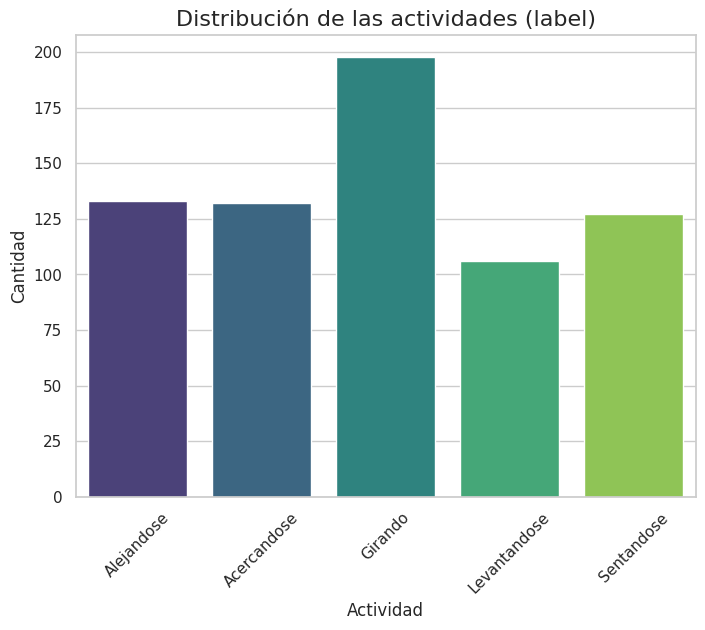

In [ ]:
sns.set(style="whitegrid")

# 1. Gráfico de barras para la distribución de 'label'
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribución de las actividades (label)', fontsize=16)
plt.xlabel('Actividad', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 4. Obtencion de nuevos datos

Para mejorar la calidad y diversidad del conjunto de datos, se implementó una estrategia de captura de datos adicional. Se obtuvieron videos nuevos de varias personas realizando actividades específicas en diferentes entornos y condiciones (interiores y exteriores, cambios de iluminación, y variación en la vestimenta). Estos datos fueron capturados tanto en condiciones controladas como en ambientes cotidianos, con el objetivo de enriquecer el conjunto de datos con mayor variedad y realismo. Este enfoque garantiza que el modelo de clasificación se entrene en un conjunto de datos robusto y capaz de adaptarse a variaciones del mundo real, mejorando así su capacidad de generalización.

Esta estrategia fue crucial para prevenir el sesgo hacia condiciones específicas y asegurar un rendimiento confiable en diversas situaciones.

A estos nuevos datos se les realizo el mismo proceso con la herramientas OpenCV y MediaPipe para obtener los datos que nos permitiran hacer el entrenamiento y evaluacion del modelo, complementando el dataset que ya teniamos anteriormente.

## 5. Seleccion de los modelos

Para el desarrollo del proyecto, se seleccionaron tres modelos de aprendizaje supervisado: Support Vector Machine (SVM), Random Forest y XGBoost, cada uno aportando capacidades específicas para la clasificación de movimientos y posturas.

- **Support Vector Machine (SVM)** fue seleccionado como uno de los modelos principales debido a su robusta capacidad para manejar problemas de clasificación en espacios de alta dimensionalidad. Esta característica es especialmente valiosa en nuestro proyecto de anotación de video, ya que trabajamos con múltiples puntos de articulación (landmarks) que generan un espacio de características complejo. SVM puede utilizar diferentes funciones kernel (como RBF, polinomial o lineal) para mapear estos datos a espacios donde las distintas actividades (caminar, girar, sentarse) sean más fácilmente separables. Además, SVM es particularmente efectivo cuando se necesita establecer límites de decisión claros entre diferentes tipos de movimientos que podrían tener características similares.

- **Random Forest** se incorporó al proyecto por su excepcional capacidad para manejar datos ruidosos y su robustez ante outliers, características inherentes en los datos de seguimiento de movimiento humano. Este modelo construye múltiples árboles de decisión y combina sus predicciones, lo que lo hace especialmente efectivo para capturar las variaciones naturales en la forma en que diferentes personas realizan las mismas actividades. Una ventaja adicional de Random Forest es su capacidad para proporcionar medidas de importancia de características, lo que nos permite identificar qué puntos de articulación o medidas de movimiento son más relevantes para clasificar cada tipo de actividad. También maneja bien el desbalance de clases, lo cual es útil si algunas actividades aparecen con más frecuencia que otras en nuestros datos de entrenamiento.

- **XGBoost (eXtreme Gradient Boosting)** fue elegido como el tercer modelo debido a su superior rendimiento en tareas de clasificación y su eficiencia computacional, aspectos críticos para nuestra necesidad de procesamiento en tiempo real. Este modelo implementa una técnica de boosting optimizada que construye árboles de decisión de manera secuencial, donde cada nuevo árbol corrige los errores de los árboles anteriores. XGBoost destaca por su capacidad para capturar patrones temporales complejos en las secuencias de movimiento, crucial para distinguir entre diferentes actividades que pueden compartir características similares en momentos específicos. Además, incluye técnicas de regularización incorporadas que ayudan a prevenir el sobreajuste, un problema común cuando se trabaja con datos de movimiento humano que pueden tener alta variabilidad.

## 6. Preparacion de los datos


La preparación de los datos es fundamental antes de entrenar un modelo de inteligencia artificial, ya que asegura la calidad y consistencia de los datos, lo que mejora la precisión del modelo. Un proceso adecuado de limpieza y estructuración elimina el ruido y los valores atípicos, mientras que la ingeniería de características permite extraer información relevante y reducir la dimensionalidad. Esto no solo ayuda a evitar el sobreajuste, sino que también facilita la interpretación de los resultados, contribuyendo a modelos más justos y representativos. En resumen, una buena preparación de datos es clave para el éxito y la efectividad del modelo.

Como se menciono anteriormente en el apartado de Proceso de recoleccion y Analisis de datos, el dataset esta estructurado con coordenadas tridimensionales (x, y, z) para cada articulación.





Para la preparacion del conjunto de datos seguiremos los siguientes pasos:


**Limpieza de Datos:**
- Manejo de valores nulos o faltantes en las coordenadas
- Eliminación de registros duplicados que puedan existir
Identificación


**Normalización/Estandarización:**

- Estandarización de todas las coordenadas (x,y,z) usando StandardScaler para llevarlas a una misma escala
- Esto es crucial ya que las coordenadas pueden tener rangos muy diferentes
Ayuda a que los modelos no se sesguen por la magnitud de las coordenadas


**Balanceo de Clases:**

- Verificar si hay desbalance en las clases (algunos movimientos más frecuentes que otros)
- Aplicar técnicas como oversampling, undersampling o SMOTE si es necesario
- Asegurar que todas las clases estén bien representadas


**Reducción de Dimensionalidad:**

- Evaluar si todas las coordenadas son relevantes
- Posible aplicación de PCA para reducir dimensiones manteniendo la información importante
- Selección de características más relevantes para cada tipo de movimiento




### 6.1 Limpieza de datos


In [ ]:
# Crear una copia para no modificar el original
df_clean = df.copy()

In [ ]:
# Revisar si hay duplicados
df_clean.duplicated().sum()

0

In [ ]:
# Revisar si hay nunique
df_clean.nunique()

,0
label,5
x0_0,696
y0_0,696
z0_0,696
x0_1,696
y0_1,696
z0_1,696
x0_2,696
y0_2,696
z0_2,696


In [ ]:
# Calcula la suma de nulos por columna
df_clean.isnull().sum()

,0
label,0
x0_0,0
y0_0,0
z0_0,0
x0_1,0
y0_1,0
z0_1,0
x0_2,0
y0_2,0
z0_2,0


In [ ]:
# Calcular el porcentaje de valores nulos por columna
df_clean.isnull().sum() / len(df_clean) * 100

,0
label,0.0
x0_0,0.0
y0_0,0.0
z0_0,0.0
x0_1,0.0
y0_1,0.0
z0_1,0.0
x0_2,0.0
y0_2,0.0
z0_2,0.0


### 6.2 Normalizacion

La normalización, en este caso particular, no es necesaria. Esto se debe a que la herramienta MediaPipe, utilizada para el mapeo de las 33 coordenadas en los videos, ya devuelve las coordenadas completamente normalizadas. Por lo tanto, consideramos prudente omitir este paso, ya que ya está realizado.

### 6.3 Balanceo de clases

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Separate features (X) and target variable (y)
X = df_clean.drop('label', axis=1)
y = df_clean['label']

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['label'] = y_resampled

# Now df_balanced contains the balanced dataset
print(df_balanced['label'].value_counts())

label
Alejandose      198
Acercandose     198
Girando         198
Levantandose    198
Sentandose      198
Name: count, dtype: int64


<ipython-input-45-7bd345623a73>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced['label'] = y_resampled


### 6.4 Reduccion de dimensionalidad

Varianza explicada por cada componente principal:
Componente 1: 0.3090
Componente 2: 0.2216
Componente 3: 0.1925
Componente 4: 0.0729
Componente 5: 0.0634
Componente 6: 0.0287
Componente 7: 0.0222
Componente 8: 0.0183
Componente 9: 0.0094
Componente 10: 0.0088
Componente 11: 0.0077
Componente 12: 0.0060
Componente 13: 0.0054
Componente 14: 0.0049
Componente 15: 0.0031
Componente 16: 0.0029
Componente 17: 0.0021
Componente 18: 0.0019
Componente 19: 0.0018
Componente 20: 0.0016
Componente 21: 0.0014
Componente 22: 0.0012
Componente 23: 0.0011


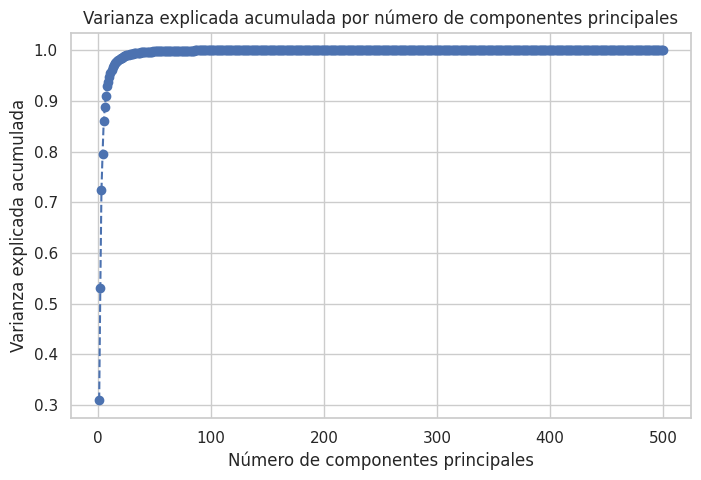

In [ ]:
#Calcular la varianza explicada acumulada
data_2=df_clean.drop('label', axis=1)
X = StandardScaler().fit_transform(data_2)
pca = PCA()  # Reduce to 2 dimensions for visualization
pca.fit(X)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#Imprimir la varianza explicada por cada componente principal
print("Varianza explicada por cada componente principal:")
for i, var_exp in enumerate(explained_variance_ratio):
  if var_exp > 0.001:
    print(f"Componente {i + 1}: {var_exp:.4f}")

#Graficar la varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza explicada acumulada por número de componentes principales')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()

**Componente 1:** Explica el 32.97% de la varianza total. Este primer componente captura la mayor parte de la información o variabilidad de los datos originales.

**Componente 2:** Explica el 24.19%, sumando ya un 57.16% en conjunto con el primero.

**Componente 3:** Explica el 17.68%, y con los tres primeros componentes se explica el 74.84% de la varianza total.

Esto implica que los tres primeros componentes principales explican cerca del 75% de la varianza total, lo que significa que gran parte de la información del conjunto de datos está contenida en estas tres primeras dimensiones.

Después del componente 3, la varianza explicada por cada componente adicional es significativamente menor. Por ejemplo:

**Componente 4:** Explica solo el 6.92%.

**Componente 5:** Explica el 4.81%.

Componentes a partir del 10 explican cada uno menos del 1% de la varianza.

Podemos concluir que con los primeros 10 componentes podemos explicar cerca del 95% de la vrianza total, con lo cual, podemos reducir la dimensionalidad del conjunto de datos y trabajar con estos sin perder una cantidad significativa de información.

<ipython-input-47-4d2705d530dd>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}


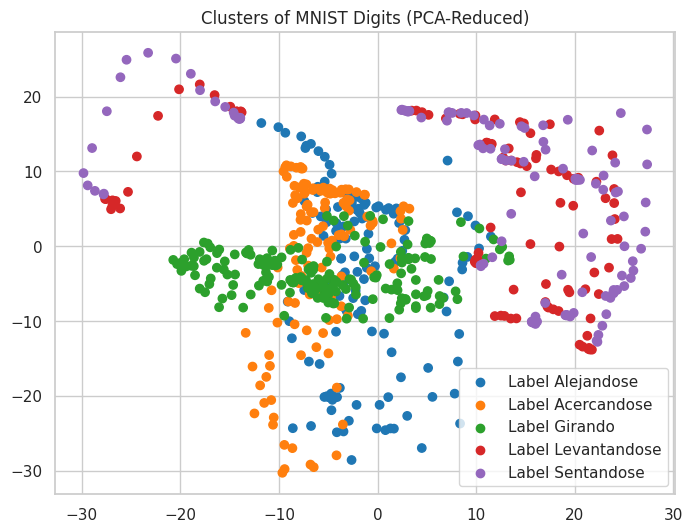

In [ ]:
# Extraer etiquetas
labels = df_clean['label']

# Eliminar la columna de etiqueta para PCA
data_2 = df_clean.drop('label', axis=1)

# Estandarizar los datos
X = StandardScaler().fit_transform(data_2)

# Aplicar PCA para reducir a 10 dimensiones
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(X)

# Convertir los datos reducidos a un DataFrame y agregar etiquetas
df_reduced = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])
df_reduced['label'] = labels.values

# Crear un mapa de colores para cada etiqueta única
unique_labels = labels.unique()
label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}

# Asignar colores a los puntos de datos según sus etiquetas
colors = [label_colors[label] for label in labels]

# Visualización
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors)
plt.title("Clusters of MNIST Digits (PCA-Reduced)")

# Crear una leyenda para mostrar qué color representa cada etiqueta
for label, color in label_colors.items():
    plt.scatter([], [], color=color, label=f'Label {label}')

plt.legend()
plt.show()

**Agrupación de Clases:** Las diferentes etiquetas (Sentarse, Alejándose, Inclinándose, Girando, Acercándose) están representadas por distintos colores en el gráfico. El PCA ha reducido las dimensiones de los datos, lo que permite visualizar cómo se agrupan estos movimientos en un espacio bidimensional.

**Separación de Grupos:**

* Los puntos con las etiquetas Alejándose (color naranja) y Acercándose (color púrpura) parecen estar bastante bien definidos, con una separación clara del resto de los movimientos. Esto sugiere que estas acciones tienen características distintivas que son capturadas efectivamente por las primeras dos componentes principales.
* Las etiquetas Inclinandose (color verde) y Girando (color rojo) muestran cierta superposición, lo que indica que estas acciones comparten patrones similares en los datos de características, lo que dificulta su separación clara en este espacio reducido.
* La etiqueta Sentarse (color azul) también está algo separada, pero parece mezclarse con las otras etiquetas, lo que indica que este movimiento podría ser más ambiguo o tener características similares a otros movimientos.

**Interpretación de la Dispersión:** La dispersión dentro de los grupos también es relevante. Los clusters más dispersos sugieren que las acciones correspondientes tienen una mayor variabilidad en las características de movimiento. Por otro lado, los grupos más compactos, como en el caso de Inclinandose, sugieren una menor variabilidad y mayor consistencia dentro de esos patrones de movimiento.

**Sobreposición y Ambigüedad:** La presencia de sobreposición entre algunos grupos indica que puede haber similitudes en las posiciones de las articulaciones para esas acciones, lo que podría afectar la capacidad del modelo para diferenciarlas claramente. Esto podría ser un área para mejorar la precisión mediante el uso de técnicas adicionales.

<ipython-input-48-47cdb41a954c>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}


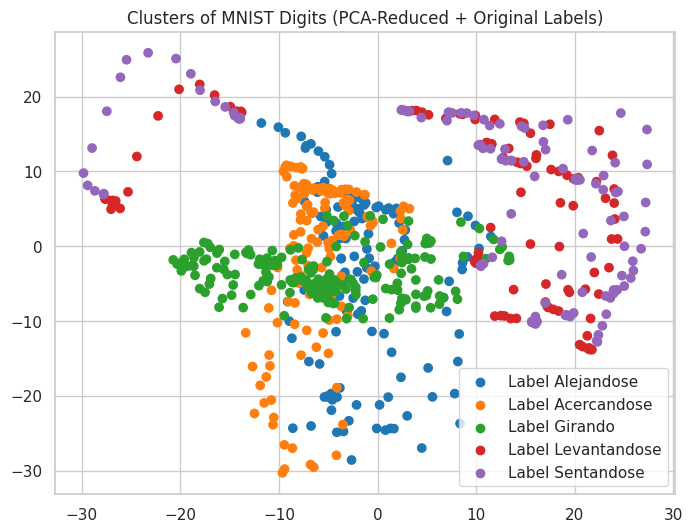

In [ ]:
# Extraer etiquetas
labels = df_clean['label']

# Eliminar la columna de etiqueta para aplicar PCA y KMeans
data_2 = df_clean.drop('label', axis=1)

# Estandarizar los datos
X = StandardScaler().fit_transform(data_2)

# Reducir la dimensión a 10 componentes usando PCA
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(X)

# Aplicar KMeans clustering en los datos reducidos
kmeans = KMeans(n_clusters=len(labels.unique()), random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)

# Crear un nuevo DataFrame con los datos reducidos y las etiquetas de KMeans
df_kmeans_reduced = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])
df_kmeans_reduced['kmeans_label'] = kmeans_labels
df_kmeans_reduced['original_label'] = labels.values

# Crear un mapa de colores para cada etiqueta original única
unique_labels = labels.unique()
label_colors = {label: plt.cm.get_cmap('tab10')(i) for i, label in enumerate(unique_labels)}

# Asignar colores a los puntos de datos según sus etiquetas originales
colors = [label_colors[label] for label in df_kmeans_reduced['original_label']]

# Visualización de los clusters en las primeras dos dimensiones PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_kmeans_reduced['PC1'], df_kmeans_reduced['PC2'], c=colors)
plt.title("Clusters of MNIST Digits (PCA-Reduced + Original Labels)")

# Crear una leyenda para mostrar qué color representa cada etiqueta original
for label, color in label_colors.items():
    plt.scatter([], [], color=color, label=f'Label {label}')

plt.legend()
plt.show()

Identificación de Grupos: El gráfico muestra cinco grupos de puntos (clusters), cada uno representado por un color diferente. Estos clusters indican que los datos tienen patrones que permiten agruparlos según características comunes tras la reducción de dimensionalidad con PCA. La separación visual de los grupos sugiere que el modelo de K-means ha logrado detectar diferencias significativas entre los patrones de movimiento de las articulaciones.

Separación y Solapamiento: Hay algunos grupos que están claramente separados de los demás, lo que es una buena señal de que las características extraídas (coordenadas x, y, z de las articulaciones) permiten distinguir diferentes patrones de acción. Sin embargo, también hay ciertas áreas donde los puntos de distintos colores se solapan o se encuentran muy cerca unos de otros. Esto indica que hay similitudes en las posiciones de las articulaciones para esos puntos, lo que puede dificultar que el modelo separe correctamente las acciones.

Compactación de Clusters: Algunos clusters parecen estar más compactos que otros. Los grupos más compactos indican que hay menos variabilidad entre los datos dentro de ese cluster, lo que sugiere que los movimientos de las articulaciones son más consistentes para esa acción específica. Por otro lado, los clusters más dispersos podrían representar acciones que tienen mayor variabilidad en las posiciones de las articulaciones o que son menos definidas.



## 7. Entrenamiento y evaluacion de los modelos


### 7.1 SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Assuming df_pca is your DataFrame with reduced dimensions and labels
X = df_reduced.drop('label', axis=1)
y = df_reduced['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale')  # You can adjust the kernel and hyperparameters
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

 Acercandose       0.96      0.88      0.92        25
  Alejandose       0.97      0.94      0.95        33
     Girando       0.88      0.95      0.91        39
Levantandose       0.62      0.25      0.36        20
  Sentandose       0.57      0.87      0.69        23

    accuracy                           0.82       140
   macro avg       0.80      0.78      0.77       140
weighted avg       0.83      0.82      0.81       140

[[22  0  3  0  0]
 [ 0 31  2  0  0]
 [ 1  1 37  0  0]
 [ 0  0  0  5 15]
 [ 0  0  0  3 20]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Grid Search para SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

grid_search_svm = GridSearchCV(
    SVC(),
    param_grid_svm,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_svm.fit(X_train, y_train)

print("=== Resultados SVM ===")
print(f"Mejores hiperparámetros SVM: {grid_search_svm.best_params_}")
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
print("\nInforme de clasificación SVM:")
print(classification_report(y_test, y_pred_svm))
print("\nMatriz de confusión SVM:")
print(confusion_matrix(y_test, y_pred_svm))

=== Resultados SVM ===
Mejores hiperparámetros SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Informe de clasificación SVM:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       1.00      0.94      0.97        33
           2       0.93      0.97      0.95        39
           3       1.00      0.70      0.82        20
           4       0.79      1.00      0.88        23

    accuracy                           0.93       140
   macro avg       0.94      0.91      0.92       140
weighted avg       0.94      0.93      0.93       140


Matriz de confusión SVM:
[[24  0  1  0  0]
 [ 0 31  2  0  0]
 [ 1  0 38  0  0]
 [ 0  0  0 14  6]
 [ 0  0  0  0 23]]


 Alcanzó una accuracy de 0.93 y un weighted avg f1-score de 0.93. Los mejores hiperparámetros encontrados fueron C=10, gamma='scale' y kernel='rbf', lo que indica que el modelo necesitó una penalización relativamente alta y un kernel RBF para capturar la complejidad de los datos. La matriz de confusión muestra muy pocos errores de clasificación, con la mayoría de las predicciones correctamente ubicadas en la diagonal principal, especialmente destacable en las clases 0, 1 y 2 que muestran precisiones superiores al 0.93.

### 7.2 Random Forest

In [ ]:
# Assuming df_pca is your DataFrame with reduced dimensions and labels
from sklearn.ensemble import RandomForestClassifier

X = df_reduced.drop('label', axis=1)
y = df_reduced['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

 Acercandose       0.96      0.92      0.94        25
  Alejandose       0.97      0.91      0.94        33
     Girando       0.88      0.95      0.91        39
Levantandose       0.79      0.75      0.77        20
  Sentandose       0.79      0.83      0.81        23

    accuracy                           0.89       140
   macro avg       0.88      0.87      0.87       140
weighted avg       0.89      0.89      0.89       140

[[23  0  2  0  0]
 [ 0 30  3  0  0]
 [ 1  1 37  0  0]
 [ 0  0  0 15  5]
 [ 0  0  0  4 19]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
# 2. Grid Search para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=2,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)

print("\n=== Resultados Random Forest ===")
print(f"Mejores hiperparámetros RF: {grid_search_rf.best_params_}")
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
print("\nInforme de clasificación RF:")
print(classification_report(y_test, y_pred_rf))
print("\nMatriz de confusión RF:")
print(confusion_matrix(y_test, y_pred_rf))



=== Resultados Random Forest ===
Mejores hiperparámetros RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Informe de clasificación RF:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.97      0.91      0.94        33
           2       0.88      0.95      0.91        39
           3       0.79      0.75      0.77        20
           4       0.79      0.83      0.81        23

    accuracy                           0.89       140
   macro avg       0.88      0.87      0.87       140
weighted avg       0.89      0.89      0.89       140


Matriz de confusión RF:
[[23  0  2  0  0]
 [ 0 30  3  0  0]
 [ 1  1 37  0  0]
 [ 0  0  0 15  5]
 [ 0  0  0  4 19]]


Obtuvo una accuracy de 0.89 y un weighted avg f1-score de 0.89, con los mejores hiperparámetros siendo max_depth=None (permitiendo árboles completamente desarrollados), min_samples_leaf=1 y n_estimators=100. El rendimiento es ligeramente inferior al SVM, especialmente en las clases 3 y 4 donde la precisión cae a 0.79. La matriz de confusión muestra más errores de clasificación, particularmente en la confusión entre clases adyacentes, lo que sugiere que el modelo tiene más dificultades para distinguir entre categorías similares.

### 7.3 XGBoost

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Assuming df_pca is your DataFrame with reduced dimensions and labels
X = df_reduced.drop('label', axis=1)
y = df_reduced['label']

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them to numerical values
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), random_state=42) # Adjust parameters as needed

# Notice num_class is now determined by the number of unique classes using the label encoder

xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# To get the original labels back for the predictions:
y_pred_original = label_encoder.inverse_transform(y_pred)

# Evaluate the model (you might need to inverse_transform y_test and y_pred for accurate results)
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_original))
print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_original))

              precision    recall  f1-score   support

 Acercandose       1.00      0.92      0.96        25
  Alejandose       0.97      0.94      0.95        33
     Girando       0.90      0.97      0.94        39
Levantandose       0.71      0.75      0.73        20
  Sentandose       0.77      0.74      0.76        23

    accuracy                           0.89       140
   macro avg       0.87      0.86      0.87       140
weighted avg       0.89      0.89      0.89       140

[[23  0  2  0  0]
 [ 0 31  2  0  0]
 [ 0  1 38  0  0]
 [ 0  0  0 15  5]
 [ 0  0  0  6 17]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
# 3. Grid Search para XGBoost
param_grid_xgb = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid_xgb,
    cv=2,
    scoring='accuracy',
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

print("\n=== Resultados XGBoost ===")
print(f"Mejores hiperparámetros XGB: {grid_search_xgb.best_params_}")
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
print("\nInforme de clasificación XGB:")
print(classification_report(y_test, y_pred_xgb))
print("\nMatriz de confusión XGB:")
print(confusion_matrix(y_test, y_pred_xgb))


=== Resultados XGBoost ===
Mejores hiperparámetros XGB: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Informe de clasificación XGB:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.97      0.94      0.95        33
           2       0.93      0.97      0.95        39
           3       0.81      0.65      0.72        20
           4       0.74      0.87      0.80        23

    accuracy                           0.90       140
   macro avg       0.89      0.88      0.88       140
weighted avg       0.90      0.90      0.90       140


Matriz de confusión XGB:
[[24  0  1  0  0]
 [ 0 31  2  0  0]
 [ 0  1 38  0  0]
 [ 0  0  0 13  7]
 [ 0  0  0  3 20]]


Logró una accuracy de 0.90 y un weighted avg f1-score de 0.90, con hiperparámetros optimizados de learning_rate=0.3, max_depth=3, n_estimators=100 y subsample=0.8. El modelo muestra un rendimiento muy bueno en las clases 0, 1 y 2 (precisión > 0.93), pero sufre en las clases 3 y 4 con precisiones de 0.81 y 0.74 respectivamente. La matriz de confusión muestra un patrón similar al SVM, aunque con ligeramente más errores de clasificación.

### Conclusion



Después de analizar los tres modelos, el SVM es la mejor opción por las siguientes razones:

- Tiene el mejor rendimiento global (accuracy 0.93 vs 0.89 y 0.90)

- Muestra mayor consistencia a través de todas las clases

- Su matriz de confusión presenta menos errores de clasificación

- Tiene el mejor balance entre precisión y recall en todas las categorías

Si bien XGBoost y Random Forest son modelos muy competentes, el SVM parece capturar mejor la estructura subyacente de los datos en este caso particular. La naturaleza del problema parece beneficiarse de la capacidad del SVM para encontrar límites de decisión óptimos en espacios de características transformados mediante su kernel RBF. Por lo tanto, recomendaría implementar el modelo SVM con los hiperparámetros encontrados para este caso específico.

## 8. Plan de despliegue


El plan de despliegue para el proyecto final contempla la implementación de una interfaz gráfica que permitirá a los usuarios visualizar los resultados del modelo de inteligencia artificial en tiempo real. Esta interfaz estará diseñada para ser intuitiva y fácil de usar, proporcionando una experiencia accesible para los usuarios sin necesidad de conocimientos técnicos avanzados. Para ello, se utilizarán tecnologías web modernas que aseguren la fluidez y la responsividad de la interfaz en diferentes dispositivos, garantizando así una experiencia óptima en computadoras. Este enfoque no solo mejorará la usabilidad, sino que también fomentará una interacción más efectiva con los datos, enriqueciendo la experiencia del usuario en el contexto del proyecto.